# 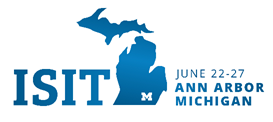 Quantum Kernels and Feature Maps with Qiskit
This hands-on session will guide you through quantum kernels and feature maps using Qiskit. You'll learn how to encode classical data into quantum states using different feature maps and how to apply quantum kernel methods to a classification task.

## 🔧 Step 1: Install Required Libraries
We'll use compatible versions of Qiskit, Qiskit Aer, and Qiskit Machine Learning.

In [ ]:
# Install required packages if not already installed
!pip install 'qiskit==0.43.1' 'qiskit-aer==0.12.0' 'qiskit-machine-learning==0.6.1' seaborn

## 📦 Step 2: Import Libraries
We import Python and Qiskit libraries for data manipulation, visualization, and quantum kernel processing.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit_aer import Aer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

## 🌸 Step 3: Load the Dataset

We use the classic Iris dataset, focusing on only 2 features for simplicity and easier visualization.

In [ ]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Normalize features to [0,1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

acc_z, acc_zz, acc_pauli = 0, 0, 0

## ❓ Step 4: Classical SVM for Comparison

Using Classical SVM, a classification is performed and the results are shwon for future comparison

Classical SVM Accuracy: 0.93


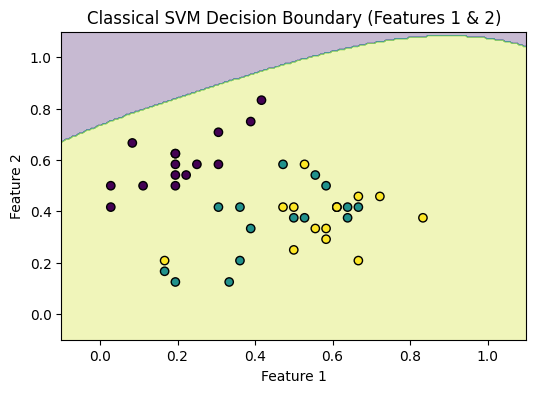

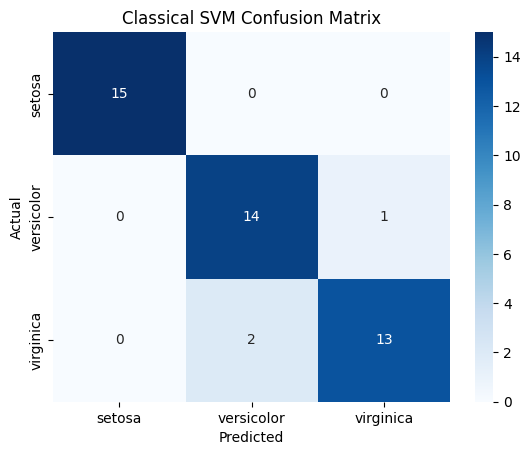

In [ ]:
# Classical SVM for comparison
clf_classical = OneVsRestClassifier(SVC(kernel='rbf', C=1.0, gamma='scale'))
clf_classical.fit(X_train, y_train)
y_pred_classical = clf_classical.predict(X_test)
acc_classical = accuracy_score(y_test, y_pred_classical)
print(f"Classical SVM Accuracy: {acc_classical:.2f}")

# Decision boundary plot on first two features
xx, yy = np.meshgrid(
    np.linspace(X_train[:,0].min() - 0.1, X_train[:,0].max() + 0.1, 200),
    np.linspace(X_train[:,1].min() - 0.1, X_train[:,1].max() + 0.1, 200)
)
# Freeze other features at their mean for visualization
mean_f2 = np.mean(X_train[:,2])
mean_f3 = np.mean(X_train[:,3])
grid = np.c_[xx.ravel(), yy.ravel(),
             np.full(xx.size, mean_f2),
             np.full(xx.size, mean_f3)]
Z = clf_classical.predict(grid).reshape(xx.shape)

plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor='k', cmap='viridis')
plt.title("Classical SVM Decision Boundary (Features 1 & 2)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classical)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Classical SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 🔍 Step 5:  Quantum Feature Maps
A quantum feature map encodes classical data into a quantum state. This transformation allows us to compute inner products between quantum states using a quantum kernel, which captures complex, non-linear relationships.

In [ ]:
def run_quantum_svm(feature_map, label):
    print(f"\nRunning QSVM with {label}...")
    backend = Aer.get_backend('statevector_simulator')
    global acc_z, acc_zz, acc_pauli
    qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

    # Evaluate kernel matrices
    K_train = qkernel.evaluate(x_vec=X_train)
    K_test = qkernel.evaluate(x_vec=X_test, y_vec=X_train)

    # Regularize kernel matrix
    K_train += 1e-6 * np.eye(K_train.shape[0])

    # Grid search for C
    param_grid = {'estimator__C': [0.1, 1, 10]}
    svc = SVC(kernel='precomputed')
    ovr = OneVsRestClassifier(svc)
    gs = GridSearchCV(ovr, param_grid, cv=5)
    gs.fit(K_train, y_train)

    y_pred = gs.predict(K_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Best C: {gs.best_params_['estimator__C']}")
    print(f"{label} QSVM Accuracy: {acc:.2f}")

    if label == 'PauliFeatureMap':
        acc_pauli = accuracy_score(y_test, y_pred)
    elif label == 'ZZFeatureMap':
        acc_zz = accuracy_score(y_test, y_pred)
    elif label == 'ZFeatureMap':
        acc_z = accuracy_score(y_test, y_pred)

    # Plot kernel matrix
    sns.heatmap(K_train, cmap='viridis')
    plt.title(f"{label} Kernel Matrix")
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=iris.target_names, yticklabels=iris.target_names)
    plt.title(f"Confusion Matrix - {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc

## 🧪 Step 6: Run with ZFeatureMap
The ZFeatureMap applies single-qubit Z rotations and is the simplest form of feature map.


Running QSVM with ZFeatureMap...
Best C: 1
ZFeatureMap QSVM Accuracy: 0.93


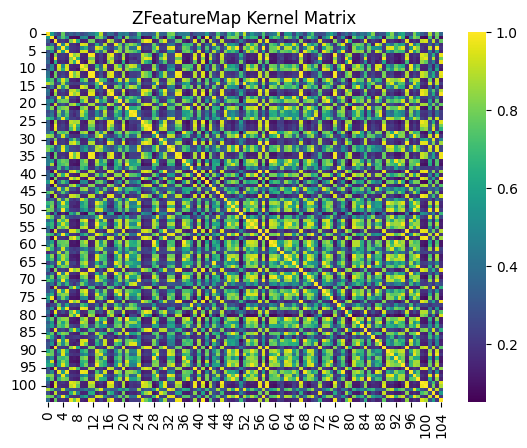

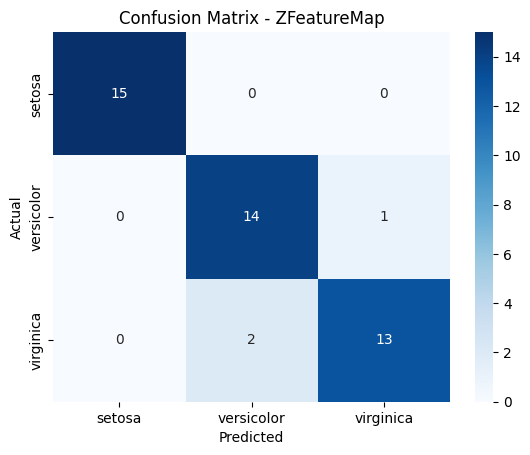

0.9333333333333333

In [ ]:
run_quantum_svm(ZFeatureMap(feature_dimension=X.shape[1], reps=3), 'ZFeatureMap')

## 🧪 Step 7: Run with ZZFeatureMap

The ZZFeatureMap uses entangling ZZ interactions and is useful for capturing correlations between qubits.


Running QSVM with ZZFeatureMap...
Best C: 1
ZZFeatureMap QSVM Accuracy: 0.80


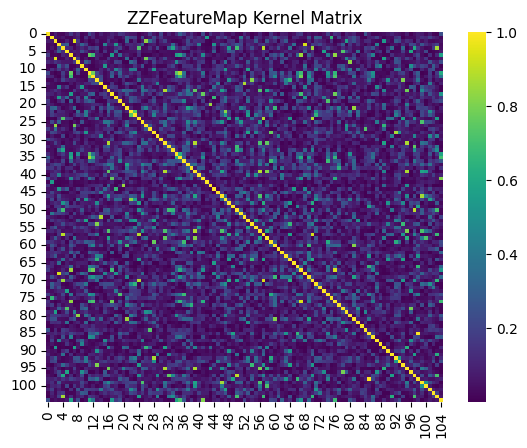

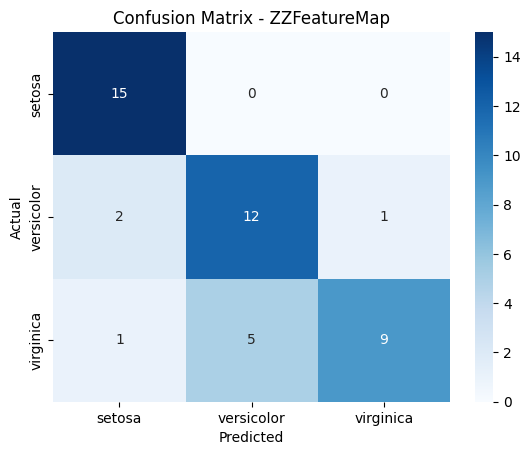

0.8

In [ ]:
run_quantum_svm(ZZFeatureMap(feature_dimension=X.shape[1], reps=3, entanglement='full'), 'ZZFeatureMap')

## 🧪 Step 8: Run with PauliFeatureMap
The PauliFeatureMap allows combinations of Pauli operations (`X`, `Y`, and `Z`) and is more flexible than ZZFeatureMap.


Running QSVM with PauliFeatureMap...
Best C: 0.1
PauliFeatureMap QSVM Accuracy: 0.91


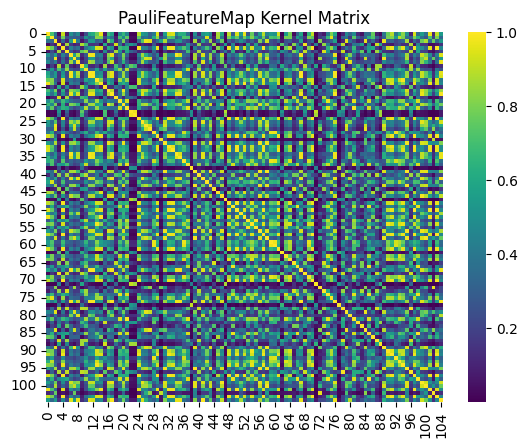

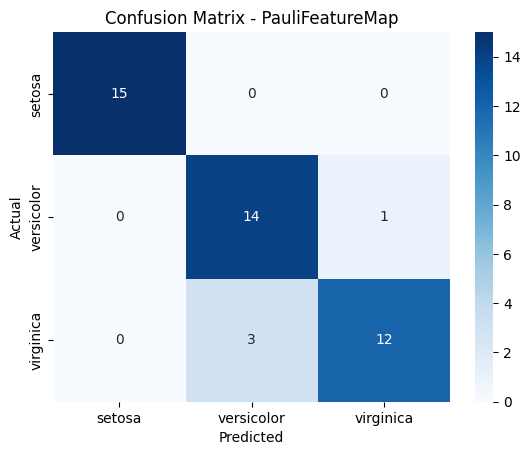

0.9111111111111111

In [ ]:
run_quantum_svm(PauliFeatureMap(feature_dimension=X.shape[1], reps=3, paulis=['X','Y','Z']), 'PauliFeatureMap')

## ❓ Step 9: Accuracy Comparison
The Classical SVM and the Quantum SVM accuracy comparison.

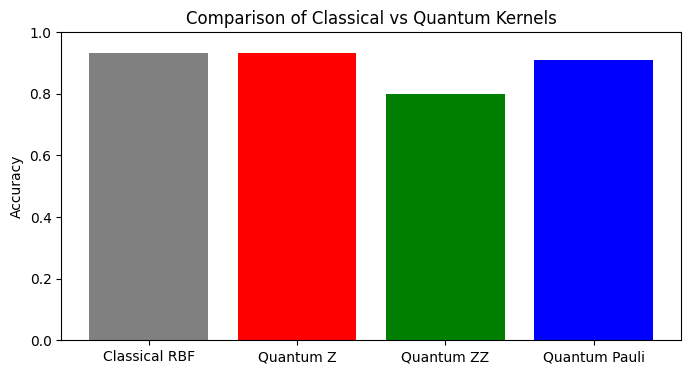


Summary of QSVM Accuracies:
ClassicalFeatureMap: 0.93
ZFeatureMap: 0.93
ZZFeatureMap: 0.80
PauliFeatureMap: 0.91


In [ ]:
import matplotlib.pyplot as plt

methods = ['Classical RBF', 'Quantum Z', 'Quantum ZZ', 'Quantum Pauli']
accuracies = [acc_classical, acc_z, acc_zz, acc_pauli]

plt.figure(figsize=(8, 4))
plt.bar(methods, accuracies, color=['gray', 'red', 'green', 'blue'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Classical vs Quantum Kernels')
plt.show()

# Summary
print("\nSummary of QSVM Accuracies:")
print(f"ClassicalFeatureMap: {acc_classical:.2f}")
print(f"ZFeatureMap: {acc_z:.2f}")
print(f"ZZFeatureMap: {acc_zz:.2f}")
print(f"PauliFeatureMap: {acc_pauli:.2f}")

## ✅ Summary
In this session, you:
- Learned what quantum feature maps are and why they matter.
- Used **Qiskit Machine Learning** to compute quantum kernel matrices.
- Trained multi-class SVMs on quantum kernels.
- Compared classical and quantum feature maps: **ZZFeatureMap**, **PauliFeatureMap**, and **ZFeatureMap**.

Happy quantum learning! ⚛️🚀